In [12]:
# %matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 20)

import networkx as nx
import matplotlib.pyplot as plt
import pickle
import numpy as np
from skimage import data, io, filters
from skimage.feature import canny
from scipy import ndimage as ndi
from skimage.filters import sobel
from skimage.morphology import watershed
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb, rgb2gray
import cv2
from scipy.misc import imread, imshow
from scipy.ndimage import label
from scipy import asarray, ones, vstack, hstack
from sys import stdout
import argparse
import os

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
def ROI(image, x1,x2,y1,y2):
    roi_image = image[x1:x2,y1:y2]
    return roi_image

In [3]:
def basicProcessing(roiBF):
    
    ## Convert a color rgb image to gray 
    worm = roiBF
    
    ## plot histogram to check the range for markers (Do it for one image in an experimental dataset)
    #histo = np.histogram(worm, bins=np.arange(0, 256))
    #plt.figure(1)
    #plt.hist(histo)
    #plt.plot(histo[1][:-1], histo[0], lw=2)
    
    # Blur the rough edges in the image
    blur = cv2.blur(worm,(2,2))
    #plt.figure(2)
    #plt.imshow(worm, cmap='gray')

    # Calculate the elevation map through a filter called sobel in skimage.filters
    elevation_map = sobel(blur)
    #plt.figure(5)
    #plt.imshow(elevation_map, cmap='gray')

    # Calculate the marker threshold of worms
    markers = np.zeros_like(blur)
    markers[worm < 4000] = 1
    markers[worm > 15000] = 2
    #plt.figure(6)
    #plt.imshow(markers, cmap='gray', interpolation='nearest')

    ## Determine segmentation of individual worms using the elevation map and marker thresholding
    segmentation = watershed(elevation_map, markers)
    #plt.figure(7)
    #plt.imshow(segmentation, cmap='gray', interpolation='nearest')
    return segmentation

In [4]:
def basicProcessingBF(roiBF):
    
    ## Convert a color rgb image to gray 
    worm = roiBF
    floatBF = worm/float(worm.max())
    
    ## Apply a Gaussian Blur
    blur = cv2.blur(floatBF,(30,30))
    #plt.figure()
    #plt.imshow(blur)
    
    ## Subtract background
    bgSub = floatBF - blur
    #plt.figure(1)
    #plt.imshow(bgSub, cmap='gray')
    
    bgSubFloat = bgSub/float(bgSub.max())
    #plt.figure(2)
    #plt.imshow(bgSubFloat, cmap='gray')
    
    ## Threshold for worm selection
    thresh = threshold_otsu(bgSubFloat)
    bw = closing(bgSubFloat > thresh, square(3))
    #plt.figure(1)
    #plt.imshow(bw, cmap='gray', interpolation='nearest')
    segmentation = np.zeros_like(bw)
    segmentation[bw == 0] = 1
    segmentation[bw == 1] = 0
    return segmentation

In [6]:
def labelSegments(segmentedImage):
    
    ### Segmented image has segments in black and background in white. Change it to opposite.
    #segmentedImage[segmentedImage>1] = 0
    #segmentedImage[segmentedImage == 1] = 2
    #plt.imshow(img_rmv, cmap = 'gray')
    
    ## Label segments and count them
    label_objects, nb_labels = ndi.label(segmentedImage, ones((3,3)))
    
    ## Get the size of each object
    sizes = np.bincount(label_objects.ravel())
    
    ## Threshold mask size. All segments greater than this threshold size is kept. Others are removed.
    mask_sizes = np.logical_and(sizes>=600, sizes<=1200)
    #print mask_sizes
    mask_sizes[0] = 0
    worms_cleaned = mask_sizes[label_objects]
    # plt.imshow(label_objects)
    #plt.imshow(worms_cleaned, cmap='gray')
    
#     ## Threshold mask size. All segments lesser than this threshold size is kept. Others are removed.
#     im_labeled2, n_labels2 = ndi.label(worms_cleaned, ones((3,3)))
#     # plt.imshow(im_labeled)
#     sizes2 = np.bincount(im_labeled2.ravel())
#     mask_sizes2 = sizes2 < 1200
#     mask_sizes2[0] = 0
#     worms_cleaned2 = mask_sizes2[im_labeled2]
#     # plt.imshow(label_objects)
#     #plt.imshow(worms_cleaned2, cmap='gray')
    
    ## Label the padded and segmented roi image
    labeled2, n2 = ndi.label(worms_cleaned)
    objects_per_unit_area2 = (n2-1) * 1.0 / worms_cleaned.size
    #plt.imshow(labeled2)
    
    return (labeled2, n2)
   

In [7]:
def basicProcessingGlowy(roiGlowy, blurIntensity):
    worm = roiGlowy
    
    ## Enhance Image by removing noise
    unevenFloat = worm/float(worm.max())
    #plt.figure()
    #plt.imshow(unevenFloat)
    
    ## Apply a Gaussian Blur
    blur = cv2.blur(unevenFloat,(blurIntensity,blurIntensity))
    #plt.figure()
    #plt.imshow(blur)
    
    ## Subtract background
    bgSub = unevenFloat - blur
    #plt.figure()
    #plt.imshow(bgSub)
    return bgSub

In [8]:
def properties(labeledImage, glowyImage):
    
    ## Get all properties of labeled image
    props = regionprops(labeledImage, intensity_image=glowyImage)
    
    ## Extract a specific property
    # Extract the mean intensities
    mean_int = np.array([prop.mean_intensity for prop in props])
    crow = np.array([prop.centroid[0] for prop in props])
    ccol = np.array([prop.centroid[1] for prop in props])
    
    return props, mean_int
    

In [9]:
# Define the function for computing the ECDF.
def ecdf(data):
    """Compute x, y values for an empirical distribution function."""
    x = np.sort(data)
    y = np.arange(1, len(data)+1) / float(len(data))
    return x, y

In [10]:
def bootstrapData(data):

    # Define number of repetitions.
    n_reps = 100000

    # Initialize replicates.
    bootstrappedData = np.empty(n_reps)

    # Compute replicates. We'll plot each bootstrap as we go along
    for i in range(n_reps):
        resample = np.random.choice(data, replace=True, size=len(data))
        bootstrappedData[i] = np.mean(resample)
        
    return bootstrappedData

array = 3
merged t21.tif
22


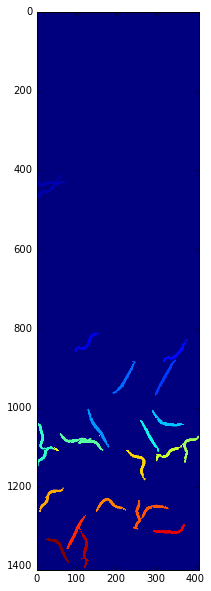

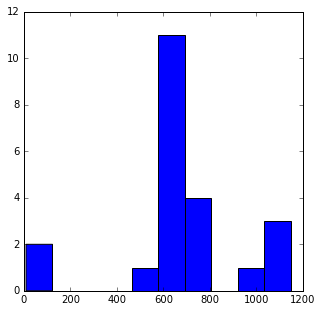

In [18]:
maindir = '/Volumes/RATI_2TB/work2017/InfectionImaging/2017.03.10 N2 and pmk-1 PA14 pAA100 to PA14 pKL3/PA14 pKL3/merged.stitch/'
arrays = ['A01', 'A04', 'A05', 'A06', 'A07']
channel = ['BF', 'DsRed', 'EGFP']

x0 = 10
xf = 1420
y0 = 20
yf = 430
trange = 40
meansRF = np.zeros((5,trange))
meansGF = np.zeros((5,trange))
intsRF = dict()
intsGF = dict()
for i in range(0,4):
    print 'array = ' +str(i)
    for j in range(21, 22):
        filename = 'merged t'+ str(j).zfill(2) + '.tif'
        print filename
        filepath_bf = os.path.join(maindir, arrays[i], channel[0], filename)
        filepath_rf = os.path.join(maindir, arrays[i], channel[1], filename)
        filepath_gf = os.path.join(maindir, arrays[i], channel[2], filename)
        #print filepath_bf
        image_bf = rgb2gray(io.imread(filepath_bf))
        image_rf = io.imread(filepath_rf)
        image_gf = io.imread(filepath_gf)
        roi_bf = ROI(image_bf,x0,xf,y0,yf)
        roi_rfp = ROI(image_rf,x0,xf,y0,yf)
        roi_gfp = ROI(image_gf,x0,xf,y0,yf)
        bgSubRF = basicProcessingGlowy(roi_rfp,10)
        bgSubGF = basicProcessingGlowy(roi_gfp,5)
        
#         plt.figure(1)
#         plt.imshow(roi_bf, cmap='gray')
#         plt.figure(2)
#         plt.imshow(roi_rfp)
#         plt.figure(3)
#         plt.imshow(roi_gfp)
#         plt.figure(4)
#         plt.imshow(bgSubRF)
#         plt.figure(5)
#         plt.imshow(bgSubGF)
        
        
        segmentedBF = basicProcessingBF(roi_bf)
        labeled = labelSegments(segmentedBF)
        labeledBF = labeled[0]
        nSegments = labeled[1]
        plt.figure(6, figsize=(10,10))
        plt.imshow(labeledBF)
        print nSegments
        (props1, meanIntensityRF) = properties(labeledBF, bgSubRF)
        (props2, meanIntensityGF) = properties(labeledBF, bgSubGF)
        areaRF = np.array([prop.area for prop in props1])
        plt.figure(7, figsize=(5,5))
        plt.hist(areaRF)
#         print meanIntensityRF
        meansRF[i,j-1] = sum(meanIntensityRF)/len(meanIntensityRF)
        meansGF[i,j-1] = sum(meanIntensityGF)/len(meanIntensityGF)
        intsRF[i,j-1] = meanIntensityRF
        intsGF[i,j-1] = meanIntensityGF
#         bootstrapMeansRF = bootstrapData(meanIntensityRF)
#         bootstrapMeansGF = bootstrapData(meanIntensityGF)
#         percsRF = np.percentile(bootstrapMeansRF, 97.5)
#         percsGF = np.percentile(bootstrapMeansGF, 97.5)
#         meansRF[i,j-1] = percsRF
#         meansGF[i,j-1] = percsGF        
        
        # Compute the ECDF
#         bs_means, bs_ECDF = ecdf(bootstrap_means)
#         plt.plot(bs_means, bs_ECDF, marker='.', linestyle='none')
#         plt.xlabel('mean of bootstrapped intensities')
#         plt.ylabel('ECDF')
#         plt.margins(0.02)

        
        
        
        
        
        


In [259]:
a = np.array([1, 3, 5, 6, 9, 10, 14, 15, 56])
print np.logical_and(a>=6, a<=10)
# np.where(np.logical_and(a>=6, a<=10))

[False False False  True  True  True False False False]


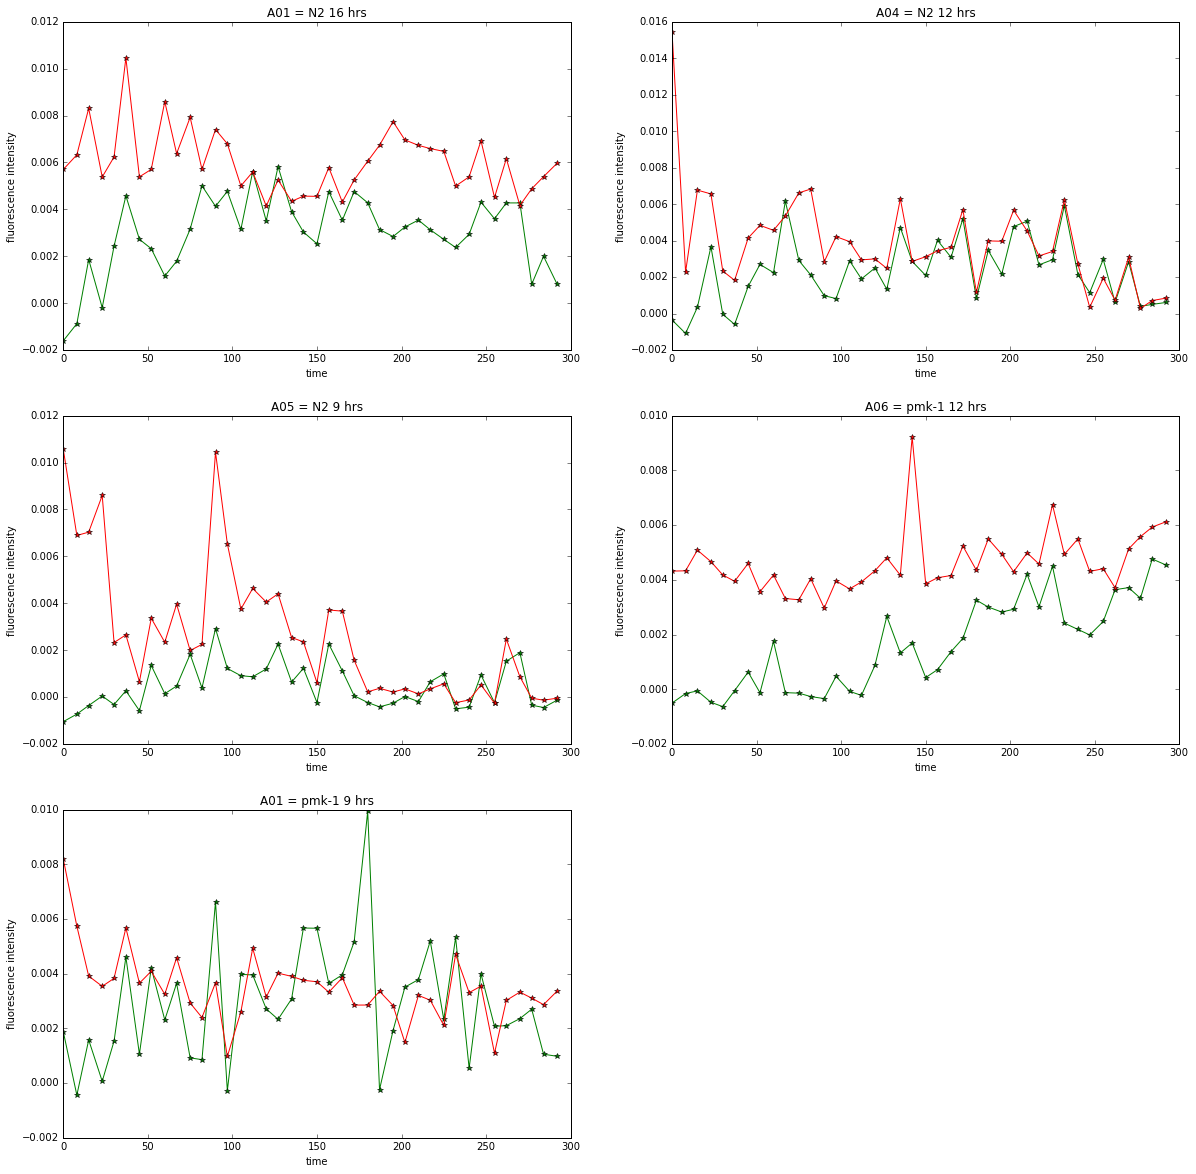

In [84]:
tfile = 'merged.tdata'
tfilepath = os.path.join(maindir, arrays[0], tfile)
time = []
lineCount = 0
with open(tfilepath, "r") as f:
    for line in f:
        lineCount += 1
        if lineCount > 3:
            time.append(line)
trange = 40
plt.figure(1)
plt.subplot(321)
intsregRF = []
intsregGF = []
for j in range(0,trange):
    intsregRF.append((intsRF[0,j]))
    intsregGF.append((intsGF[0,j]))
# print intsregRF
# for t, RF in zip(time, intsregRF):
#     plt.scatter([t] * len(RF), RF, color = 'red')
# for t, GF in zip(time, intsregGF):
#     plt.scatter([t] * len(GF), GF, color = 'green')
plt.plot(time[:trange], meansGF[0,:].T, 'g*-', label='GFP')
plt.plot(time[:trange], meansRF[0,:].T, 'r*-', label = 'DsRed')
plt.title('A01 = N2 16 hrs')
plt.xlabel('time')
plt.ylabel('fluorescence intensity')

plt.subplot(322)
intsregRF = []
intsregGF = []
for j in range(0,trange):
    intsregRF.append((intsRF[1,j]))
    intsregGF.append((intsGF[1,j]))
# print intsregRF
# for t, RF in zip(time, intsregRF):
#     plt.scatter([t] * len(RF), RF, color = 'red')
# for t, GF in zip(time, intsregGF):
#     plt.scatter([t] * len(GF), GF, color = 'green')
plt.plot(time[:trange], meansGF[1,:].T, 'g*-', label = 'GFP')
plt.plot(time[:trange], meansRF[1,:].T, 'r*-', label = 'DsRed')
plt.title('A04 = N2 12 hrs')
plt.xlabel('time')
plt.ylabel('fluorescence intensity')

plt.subplot(323)
intsregRF = []
intsregGF = []
for j in range(0,trange):
    intsregRF.append((intsRF[2,j]))
    intsregGF.append((intsGF[2,j]))
# print intsregRF
# for t, RF in zip(time, intsregRF):
#     plt.scatter([t] * len(RF), RF, color = 'red')
# for t, GF in zip(time, intsregGF):
#     plt.scatter([t] * len(GF), GF, color = 'green')
plt.plot(time[:trange], meansGF[2,:].T, 'g*-', label = 'GFP')
plt.plot(time[:trange], meansRF[2,:].T, 'r*-', label = 'DsRed')
plt.title('A05 = N2 9 hrs')
plt.xlabel('time')
plt.ylabel('fluorescence intensity')

plt.subplot(324)
intsregRF = []
intsregGF = []
for j in range(0,trange):
    intsregRF.append((intsRF[3,j]))
    intsregGF.append((intsGF[3,j]))
# print intsregRF
# for t, RF in zip(time, intsregRF):
#     plt.scatter([t] * len(RF), RF, color = 'red')
# for t, GF in zip(time, intsregGF):
#     plt.scatter([t] * len(GF), GF, color = 'green')
plt.plot(time[:trange], meansGF[3,:].T, 'g*-', label = 'GFP')
plt.plot(time[:trange], meansRF[3,:].T, 'r*-', label = 'DsRed')
plt.title('A06 = pmk-1 12 hrs')
plt.xlabel('time')
plt.ylabel('fluorescence intensity')

plt.subplot(325)
intsregRF = []
intsregGF = []
for j in range(0,trange):
    intsregRF.append((intsRF[4,j]))
    intsregGF.append((intsGF[4,j]))
# print intsregRF
# for t, RF in zip(time, intsregRF):
#     plt.scatter([t] * len(RF), RF, color = 'red')
# for t, GF in zip(time, intsregGF):
#     plt.scatter([t] * len(GF), GF, color = 'green')
plt.plot(time[:trange], meansGF[4,:].T, 'g*-', label='GFP')
plt.plot(time[:trange], meansRF[4,:].T, 'r*-', label = 'DsRed')
plt.title('A01 = pmk-1 9 hrs')
plt.xlabel('time')
plt.ylabel('fluorescence intensity')

plt.show()

# axarr[0, 1].plot(time[:40], meansGF[1,:].T)
# axarr[0, 1].plot(time[:40], meansRF[1,:].T)
# axarr[0, 1].set_title('A04 = N2 12 hrs')
# # axarr[0, 1].xlabel('time')
# # axarr[0, 1].ylabel('fluorescence intensity')

# axarr[1, 0].plot(time[:40], meansGF[2,:].T)
# axarr[1, 0].plot(time[:40], meansRF[2,:].T)
# axarr[1, 0].set_title('A05 = N2 9 hrs')
# # axarr[1, 0].xlabel('time')
# # axarr[1, 0].ylabel('fluorescence intensity')

# axarr[1, 1].plot(time[:40], meansGF[3,:].T)
# axarr[1, 1].plot(time[:40], meansRF[3,:].T)
# axarr[1, 1].set_title('A06 = pmk-1 16 hrs')
# # axarr[1, 1].xlabel('time')
# # axarr[1, 1].ylabel('fluorescence intensity')

# axarr[2, 0].plot(time[:40], meansGF[4,:].T)
# axarr[2, 0].plot(time[:40], meansRF[4,:].T)
# axarr[2, 0].set_title('A07 = pmk-1 12 hrs')
# # axarr[2, 0].xlabel('time')
# # axarr[2, 0].ylabel('fluorescence intensity')

# # for i in range(1,6):
# #     plt.figure(i)
# #     plt.plot(time,meansGF[i,:].T)
# #     plt.plot(t,meansRF[i,:].T)

In [20]:
meansRF[2:]

array([[ 1946.34759789,  1933.71266466,  1921.92728252,  1896.55061745,
         1907.19595328,  1894.74866549,  1863.2891054 ,  1853.18125662,
         1843.58621706,  1813.66590243,  1807.11521022,  1814.70040455,
         1886.03984332,  1805.318061  ,  1794.24701574,  1790.53552664,
         1776.66925956,  1776.96061313,  1772.78787802,  1779.23119203,
         1766.06134434,  1754.48696671,  1754.73799889,  1748.6291073 ,
         1743.88557817,  1741.88198942,  1752.1759104 ,  1752.78534177,
         1741.1507958 ,  1735.6406716 ,  1735.50876268,  1732.60843411,
         1726.31503761,  1733.05046643,  1730.83442386,  1732.56494436,
         1735.03565562,  1741.21993243,  1734.51866393,  1730.3127284 ],
       [ 2701.73896879,  2620.95571734,  2538.98771984,  2538.65070642,
         2490.8002516 ,  2495.68125888,  2492.28423202,  2523.45947378,
         2496.26840688,  2457.77668352,  2465.64992646,  2438.86802993,
         2461.29826572,  2467.32116871,  2459.14626027,  2443.8

In [83]:
import pickle
pickle.dump( meansGF, open( os.path.join(maindir,"meansGF.p"), "wb" ) )
pickle.dump( meansRF, open( os.path.join(maindir,"meansRF.p"), "wb" ) )
pickle.dump( intsGF, open( os.path.join(maindir,"intsGF.p"), "wb" ) )
pickle.dump( intsRF, open( os.path.join(maindir,"intsRF.p"), "wb" ) )
pickle.dump( time, open( os.path.join(maindir,"time.p"), "wb" ) )

In [3]:
meansGFprev = pickle.load(open( "/Users/ratisharma/Documents/Projects/ImageAnalysis/worms/python/meansGFprev.p", "rb" ) )
meansRFprev = pickle.load(open( "/Users/ratisharma/Documents/Projects/ImageAnalysis/worms/python/meansRFprev.p", "rb" ) )
timeprev = pickle.load(open( "/Users/ratisharma/Documents/Projects/ImageAnalysis/worms/python/timeprev.p", "rb" ) )
meansGF = pickle.load(open( "/Users/ratisharma/Documents/Projects/ImageAnalysis/worms/python/meansGF.p", "rb" ) )
meansRF = pickle.load(open( "/Users/ratisharma/Documents/Projects/ImageAnalysis/worms/python/meansRF.p", "rb" ) )
time = pickle.load(open( "/Users/ratisharma/Documents/Projects/ImageAnalysis/worms/python/time.p", "rb" ) )

In [4]:
print timeprev
timeprev0 = []
for t in timeprev:
    print t
    timeprev0.append(int(t)-25)

print timeprev0 

['   0\r\n', '   7\r\n', '  15\r\n']
   0

   7

  15

[-25, -18, -10]


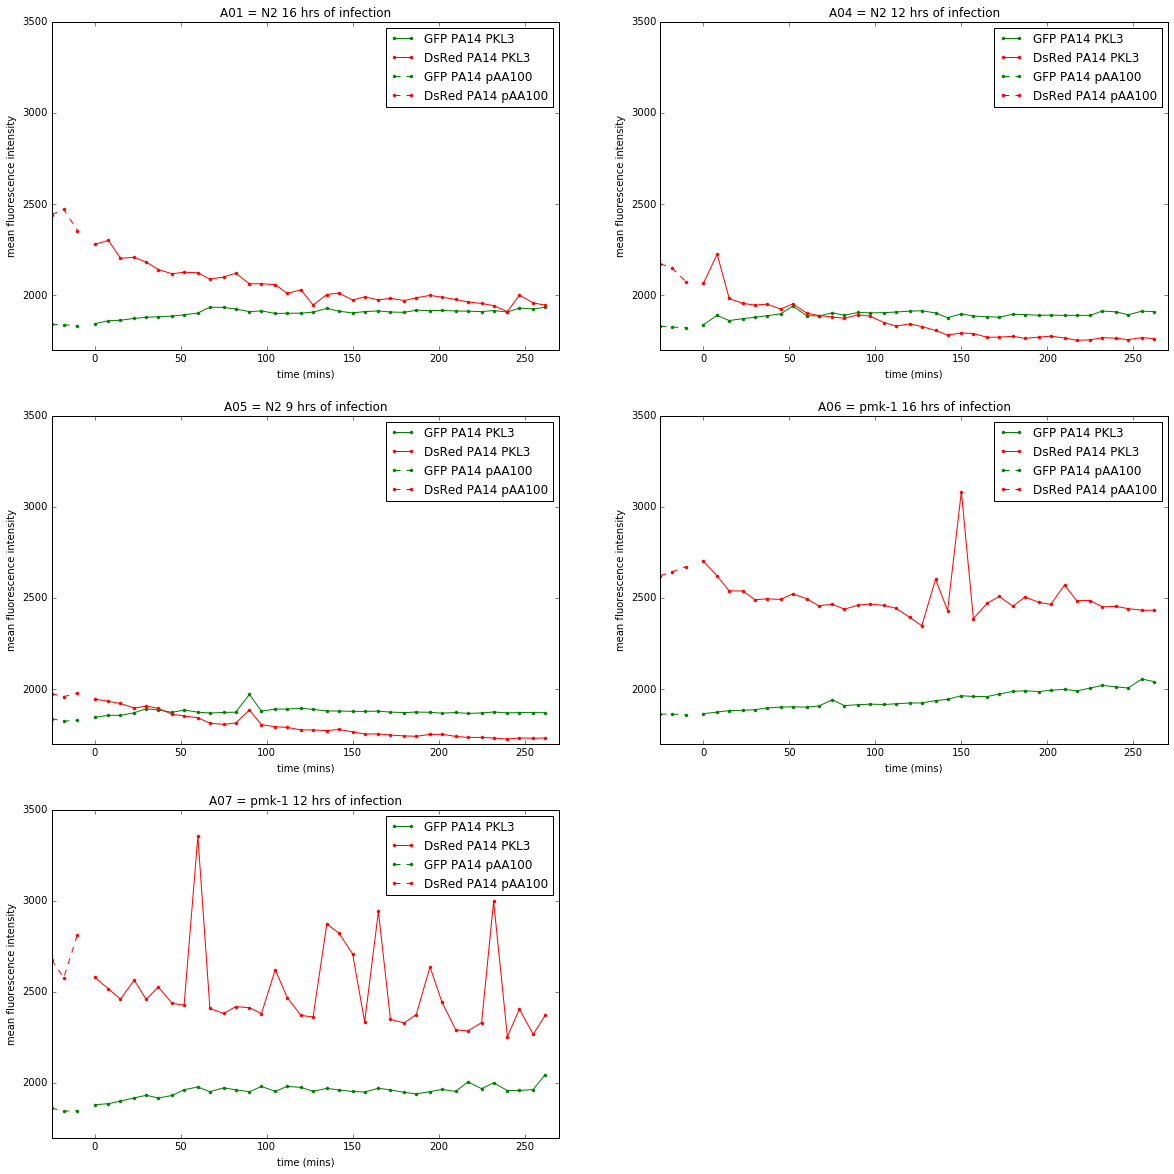

In [6]:
plt.figure(1)
plt.subplot(321)
plt.plot(time[:36], meansGF[0,:36].T, 'g.-', label='GFP PA14 PKL3')
plt.plot(time[:36], meansRF[0,:36].T, 'r.-', label = 'DsRed PA14 PKL3')
plt.plot(timeprev0[:3], meansGFprev[0,:].T, 'g.--', label='GFP PA14 pAA100')
plt.plot(timeprev0[:3], meansRFprev[0,:].T, 'r.--', label = 'DsRed PA14 pAA100')
plt.legend()
plt.xlim(-25, 270)
plt.ylim(1700, 3500)
plt.title('A01 = N2 16 hrs of infection')
plt.xlabel('time (mins)')
plt.ylabel('mean fluorescence intensity')

plt.subplot(322)
plt.plot(time[:36], meansGF[1,:36].T, 'g.-', label='GFP PA14 PKL3')
plt.plot(time[:36], meansRF[1,:36].T, 'r.-', label = 'DsRed PA14 PKL3')
plt.plot(timeprev0[:3], meansGFprev[1,:].T, 'g.--', label='GFP PA14 pAA100')
plt.plot(timeprev0[:3], meansRFprev[1,:].T, 'r.--', label = 'DsRed PA14 pAA100')
plt.legend()
plt.xlim(-25, 270)
plt.ylim(1700, 3500)
plt.title('A04 = N2 12 hrs of infection')
plt.xlabel('time (mins)')
plt.ylabel('mean fluorescence intensity')

plt.subplot(323)
plt.plot(time[:36], meansGF[2,:36].T, 'g.-', label='GFP PA14 PKL3')
plt.plot(time[:36], meansRF[2,:36].T, 'r.-', label = 'DsRed PA14 PKL3')
plt.plot(timeprev0[:3], meansGFprev[2,:].T, 'g.--', label='GFP PA14 pAA100')
plt.plot(timeprev0[:3], meansRFprev[2,:].T, 'r.--', label = 'DsRed PA14 pAA100')
plt.legend()
plt.xlim(-25, 270)
plt.ylim(1700, 3500)
plt.title('A05 = N2 9 hrs of infection')
plt.xlabel('time (mins)')
plt.ylabel('mean fluorescence intensity')

plt.subplot(324)
plt.plot(time[:36], meansGF[3,:36].T, 'g.-', label='GFP PA14 PKL3')
plt.plot(time[:36], meansRF[3,:36].T, 'r.-', label = 'DsRed PA14 PKL3')
plt.plot(timeprev0[:3], meansGFprev[3,:].T, 'g.--', label='GFP PA14 pAA100')
plt.plot(timeprev0[:3], meansRFprev[3,:].T, 'r.--', label = 'DsRed PA14 pAA100')
plt.legend()
plt.xlim(-25, 270)
plt.ylim(1700, 3500)
plt.title('A06 = pmk-1 12 hrs of infection')
plt.xlabel('time (mins)')
plt.ylabel('mean fluorescence intensity')

plt.subplot(325)
plt.plot(time[:36], meansGF[4,:36].T, 'g.-', label='GFP PA14 PKL3')
plt.plot(time[:36], meansRF[4,:36].T, 'r.-', label = 'DsRed PA14 PKL3')
plt.plot(timeprev0[:3], meansGFprev[4,:].T, 'g.--', label='GFP PA14 pAA100')
plt.plot(timeprev0[:3], meansRFprev[4,:].T, 'r.--', label = 'DsRed PA14 pAA100')
plt.legend()
plt.xlim(-25, 270)
plt.ylim(1700, 3500)
plt.title('A07 = pmk-1 9 hrs of infection')
plt.xlabel('time (mins)')
plt.ylabel('mean fluorescence intensity')

plt.show()

In [40]:
for t1 in range(0,len(time)):
    print t1, time[t1]

0    0

1    8

2   15

3   23

4   30

5   37

6   45

7   52

8   60

9   67

10   75

11   82

12   90

13   97

14  105

15  112

16  120

17  127

18  135

19  142

20  150

21  157

22  165

23  172

24  180

25  187

26  195

27  202

28  210

29  217

30  225

31  232

32  240

33  247

34  255

35  262

36  270

37  277

38  284

39  292

40  299

41  307

42  314

43  322



In [12]:
# rfp_image = io.imread('A06-t1-rfp.tif')
rfp_image = io.imread(filename_rfp)
roi_rfp =rfp_image[100:rows-19,10:cols-9]
roi_rfp.shape
labeled2.shape

(1345, 434)

In [39]:
gfp_image = io.imread(filename_gfp)
roi_gfp =gfp_image[100:rows-19,10:cols-9]
roi_rfp.shape
labeled2.shape

(1345, 434)

In [55]:
props2 = regionprops(labeled2, intensity_image=roi_gfp)
# Extract the mean intensities
mean_int2 = np.array([prop2.mean_intensity for prop2 in props2])
crow2 = np.array([prop2.centroid[0] for prop2 in props2])
ccol2 = np.array([prop2.centroid[1] for prop2 in props2])

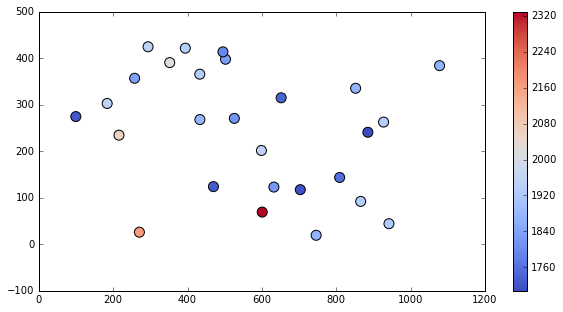

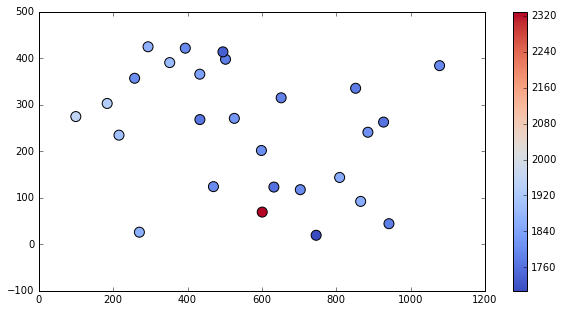

In [56]:
pylab.rcParams['figure.figsize'] = (10, 5)
# cm = plt.cm.get_cmap('RdYlBu')
sc1 = plt.scatter(crow, ccol, s=100, c=mean_int, cmap=plt.cm.coolwarm)
# sc2 = plt.scatter(crow2, ccol2, s=100, c=mean_int2, cmap=plt.cm.coolwarm)
plt.colorbar(sc)
plt.show()

sc2 = plt.scatter(crow2, ccol2, s=100, c=mean_int2, cmap=plt.cm.coolwarm)
plt.colorbar(sc)
plt.show()

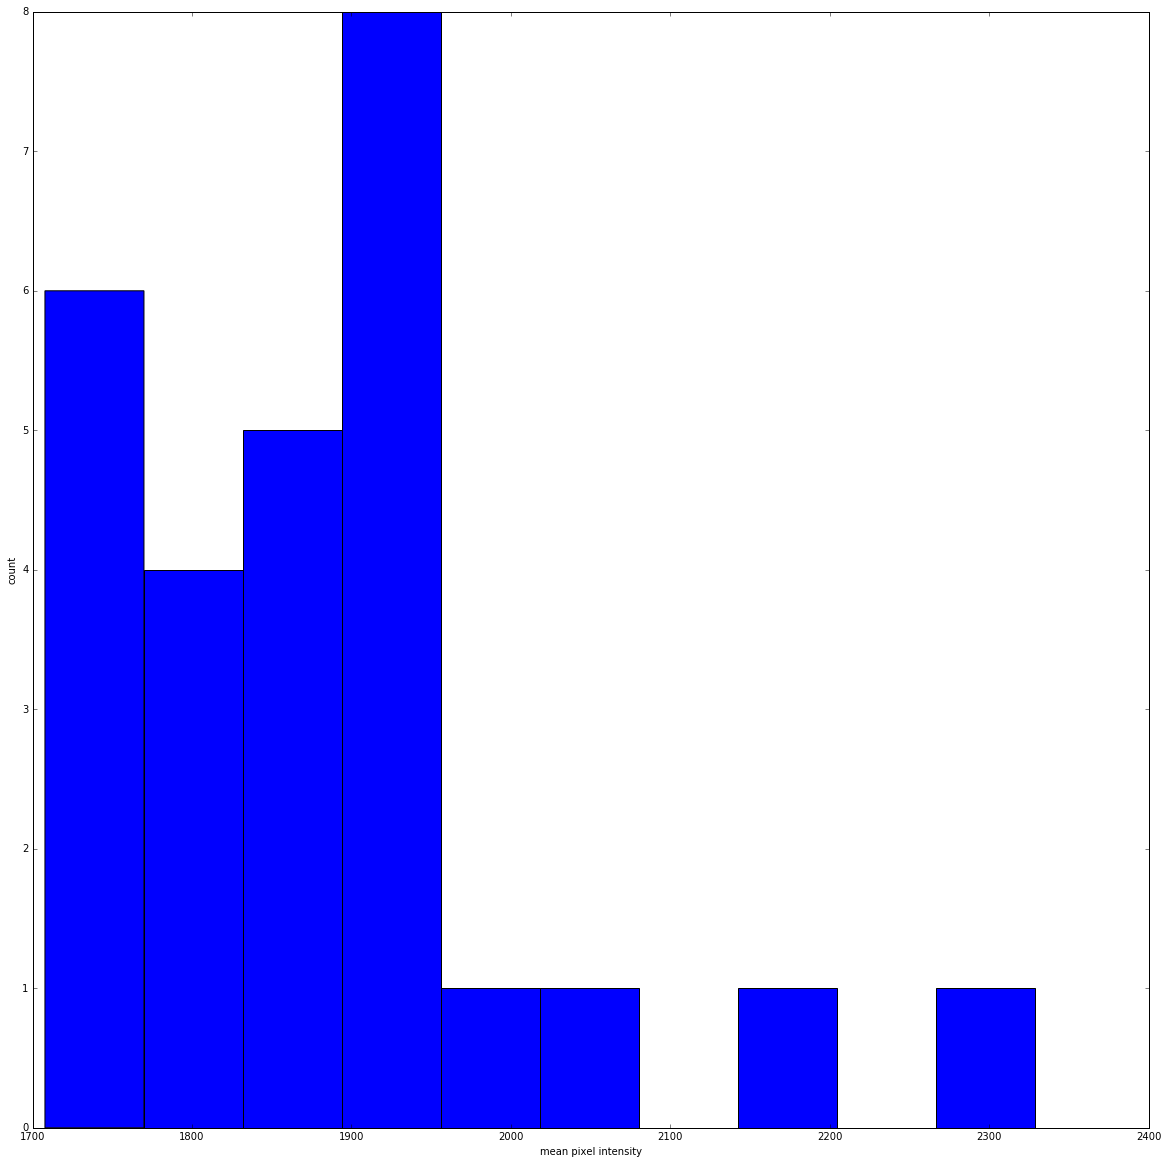

In [14]:
# We'll start with a simple histogram.
plt.hist(mean_int)
plt.xlabel('mean pixel intensity')
plt.ylabel('count')

In [5]:
# Define the function for computing the ECDF.
def ecdf(data):
    """Compute x, y values for an empirical distribution function."""
    x = np.sort(data)
    y = np.arange(1, len(data)+1) / float(len(data))
    return x, y

# Compute the ECDF for our glow-y cells. 
intensities, ECDF = ecdf(mean_int)

# Plot it. 
plt.plot(intensities, ECDF, marker='.', linestyle='none')
plt.xlabel('intensities')
plt.ylabel('ECDF')

NameError: name 'mean_int' is not defined

In [18]:
# Define number of repetitions.
n_reps = 100000

# Initialize replicates.
bootstrap_means = np.empty(n_reps)

# Compute replicates. We'll plot each bootstrap as we go along
for i in range(n_reps):
    resample = np.random.choice(mean_int, replace=True, size=len(mean_int))
    bootstrap_means[i] = np.mean(resample)

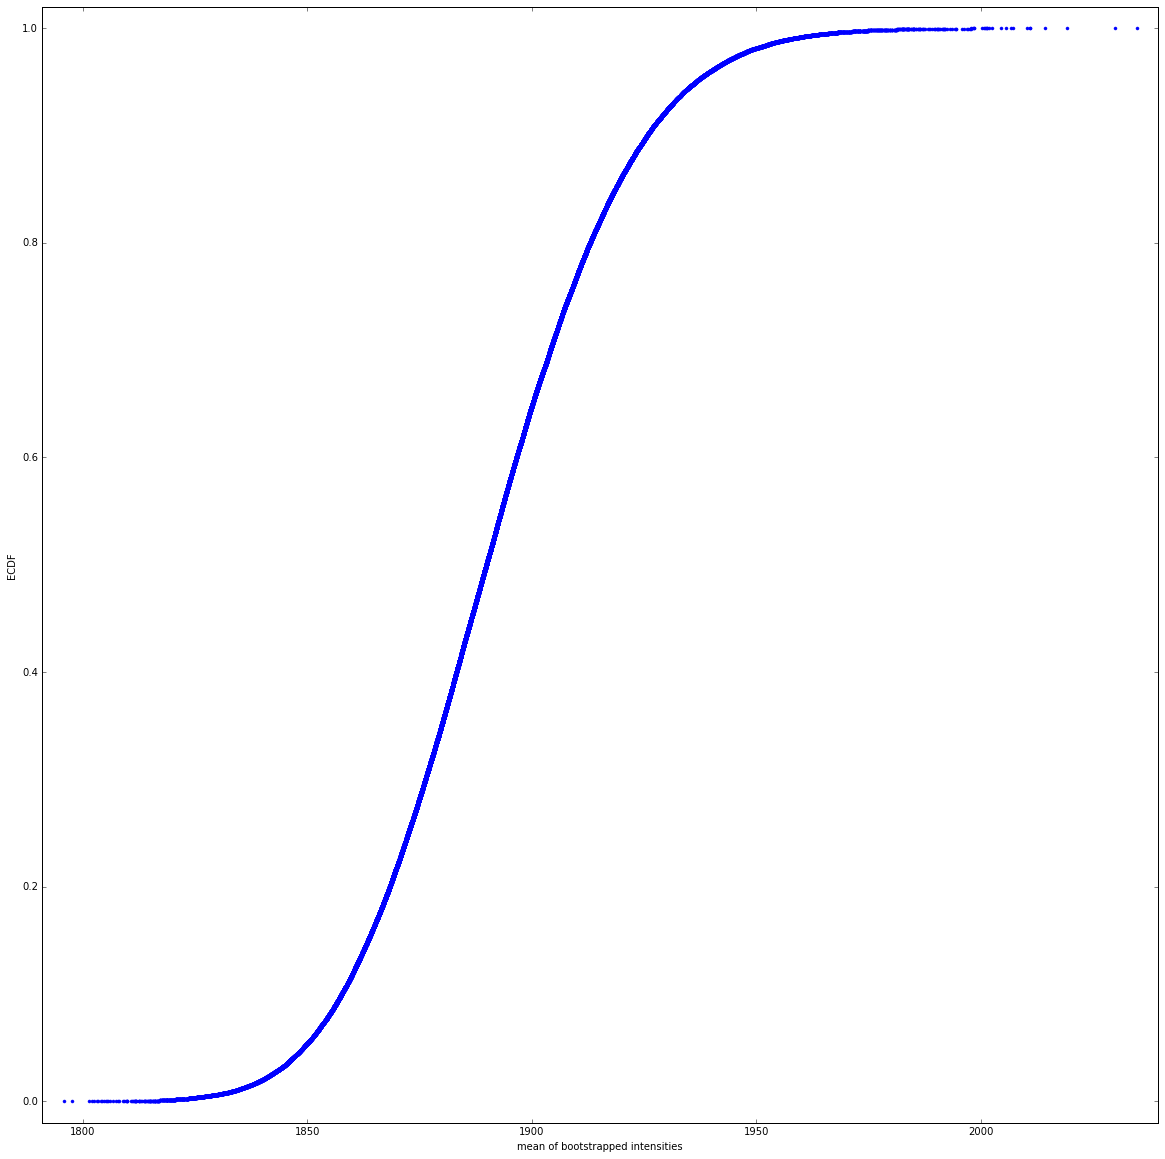

In [19]:
# Compute the ECDF
bs_means, bs_ECDF = ecdf(bootstrap_means)
plt.plot(bs_means, bs_ECDF, marker='.', linestyle='none')
plt.xlabel('mean of bootstrapped intensities')
plt.ylabel('ECDF')
plt.margins(0.02)

In [20]:
#  Compute the 95% confidence interval
percs = np.percentile(bootstrap_means, [97.5, 2.5])

print('The 97.5% and the 2.5% of the bootstrapped data are '+ str(percs[0]) + 'and ' + str(percs[1]) +', respectively.')

The 97.5% and the 2.5% of the bootstrapped data are 1946.15056511and 1842.0083367, respectively.
